# Python notebook for basic handling and visualizing Whole-slide-Images (WSIs)

## Install the necessary libraries in the Python virtual environment

[Pyvips](https://pypi.org/project/pyvips/) is a Python binding for the libvips image processing library. It is designed for efficient processing of large images, utilizing low memory and rapid execution through its underlying C-based library. Pyvips supports a wide array of image formats and operations, making it suitable for high-performance applications in image processing.

[Matplotlib](https://matplotlib.org/) is a comprehensive library for creating static, interactive, and animated visualizations in Python. It provides an extensive array of plot types and customization options, making it a tool of choice for data visualization across various domains. Matplotlib can be used in Python scripts, the Python and IPython shell, web application servers, and various graphical user interface toolkits.

[NumPy](https://numpy.org/) is a fundamental package for scientific computing in Python. It provides support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays. NumPy is essential for numerical computations and serves as the backbone for many other Python data science libraries.

[Pillow](https://python-pillow.org/) is the Python Imaging Library (PIL) Fork, an easy-to-use library for opening, manipulating, and saving many different image file formats. It is designed to be powerful yet simple and provides a solid foundation for image processing tasks in Python.

[IPyWidgets](https://ipywidgets.readthedocs.io/en/latest/) is a library for creating interactive HTML widgets for Jupyter notebooks and the IPython kernel. Widgets can be used to build interactive GUIs for your notebooks or to synchronize stateful and stateless information between Python and JavaScript.

[Scikit-image](https://scikit-image.org/) is an open-source Python library designed for image processing. It includes algorithms for segmentation, geometric transformations, color space manipulation, analysis, filtering, morphology, feature detection, and more. Skimage is built on top of NumPy, making it an integral part of the scientific Python ecosystem.

In [1]:
# !pip install pyvips, matplotlib, numpy, pillow, ipywidgets, scikit-image

## Load the libraries into the virtual environment

In [2]:
import pyvips
import matplotlib.pyplot as plt
import numpy as np

## Loading the WSI:

In [3]:
def load_slide(path):
    """
    Load a whole slide image using pyvips.
    :param path: Path to the slide file (e.g., '.svs', '.ndpi', etc.)
    :return: VipsImage object
    """
    slide = pyvips.Image.new_from_file(path, access='sequential')
    return slide


In [4]:
slide_path = 'HE.jpg'
slide = load_slide(slide_path)

## Showing basic details about the WSI:

In [5]:
def show_slide_details(slide):
    """
    Print details of the slide such as width, height, and extensive metadata.
    This function now includes detailed metadata and error handling for unsupported types.
    
    :param slide: VipsImage object
    """
    # Print basic dimensions
    print(f"Slide dimensions: {slide.width}x{slide.height}")
    
    # Access and print metadata fields with error handling
    fields = slide.get_fields()
    # print("Metadata Fields:")
    for field in fields:
        if field != 'vips-sequential':
            # Try to retrieve and print each metadata field and its value
            value = slide.get(field)
            print(f"{field}: {value}")

In [6]:
show_slide_details(slide)

Slide dimensions: 6188x12684
width: 6188
height: 12684
bands: 3
format: uchar
coding: none
interpretation: srgb
xoffset: 0
yoffset: 0
xres: 2.834645669291339
yres: 2.834645669291339
filename: HE.jpg
vips-loader: jpegload
jpeg-multiscan: 0
jpeg-chroma-subsample: 4:2:0


## Plot the WSI:

In [7]:
def display_slide(slide, title='Whole Slide Image', level=0, show_details=True):
    """
    Display a slide with improved visualization features including axes, color maps, and detailed labels.
    Provides tools for better examination of histopathological images.

    :param slide: VipsImage object
    :param level: Pyramid level to display (default is the highest resolution if pyramid is not available)
    :param show_details: Whether to display detailed information like scale and annotations
    """
    # try:
    # Handle pyramid levels
    if 'pyramid' in slide.get_fields() and level < len(slide.pyramid):
        slide = slide.pyramid[level]
    elif level != 0:
        raise ValueError(f"Requested level {level} is not available. This slide has {len(slide.pyramid)} levels.")

    # Determine the appropriate data type
    dtype = 'uint8' if slide.format == 'uchar' else 'float32' if slide.format in ['float', 'double'] else 'int32'

    # Create numpy array from the slide's buffer
    np_image = np.ndarray(buffer=slide.write_to_memory(),
                            dtype=dtype,
                            shape=[slide.height, slide.width, slide.bands])

    # Create a figure and axis for better control over display
    fig, ax = plt.subplots()
    ax.imshow(np_image)

    # Conditionally display axes details
    if show_details:
        ax.set_xlabel('Pixels')
        ax.set_ylabel('Pixels')
        ax.set_title(title)
        # Optionally add a scale bar

    # Hide axes for cleaner display if not showing details
    else:
        ax.axis('off')

    plt.show()


#

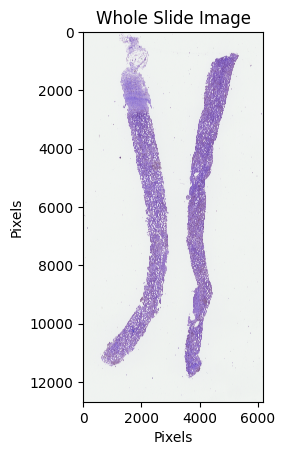

In [8]:
# Display the image, pyvips automatically handles pyramid levels
display_slide(slide, level=0, show_details=True)


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def extract_color_histogram(np_image, title="Color Histogram"):
    """
    Extract and plot the color histogram for each channel of the image.
    """
    colors = ("red", "green", "blue")
    for i, color in enumerate(colors):
        hist, bins = np.histogram(np_image[:,:,i], bins=256, range=(0, 256))
        plt.plot(hist, color=color)
        plt.xlim([0, 256])

    plt.title(title)
    plt.show()
    
def resize_image(image, scale_factor=0.5):
    """
    Resize the image by a given scale factor.
    """
    new_width = int(image.width * scale_factor)
    new_height = int(image.height * scale_factor)
    resized_image = image.resize(scale_factor)
    return resized_image

def color_normalization(np_image):
    """
    Apply color normalization to standardize the appearance of the image.
    """
    
    # Normalizing to the 0-1 range
    np_image = np_image / 255.0
    # Standard deviation normalization
    mean = np.mean(np_image, axis=(0, 1), keepdims=True)
    std = np.std(np_image, axis=(0, 1), keepdims=True)
    np_image = (np_image - mean) / std
    np_image = np.clip(np_image * 0.1 + 0.5, 0, 1)  # re-scale to 0-1 range

    return np_image

## Resize WSI


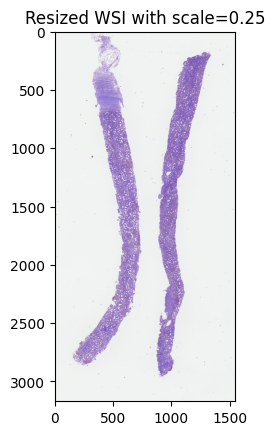

In [10]:
scale_factor = 0.25
resized_image = resize_image(load_slide(slide_path), scale_factor=scale_factor)
np_resized_image = np.ndarray(buffer=resized_image.write_to_memory(),
                          dtype=np.uint8,
                          shape=[resized_image.height, resized_image.width, resized_image.bands])



plt.figure()
plt.imshow(np_resized_image)
plt.title(f"Resized WSI with scale={scale_factor}")
plt.show()

## Basic WSI color normalization:

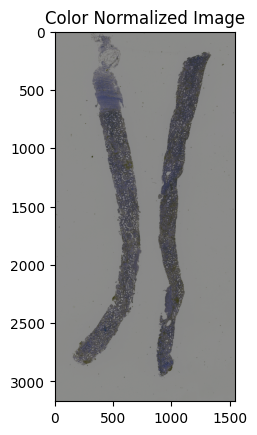

In [11]:
all_image_color_normalized = color_normalization(np_resized_image)

plt.figure()
plt.imshow(all_image_color_normalized)
plt.title("Color Normalized Image")
plt.show()

## RGB colors histogram

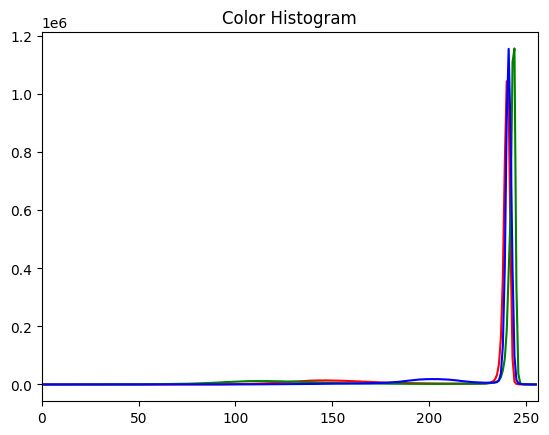

In [12]:
extract_color_histogram(np_resized_image)

## Extract the H&E tissue in WSI:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import matplotlib.patches as patches
from PIL import Image

def threshold_image(np_image, threshold=128):
    # Apply threshold and convert to binary image
    binary_image = (np.array(Image.fromarray(np_image).convert('L')) > threshold) * 255
    return binary_image.astype(np.uint8)

def display_image(binary_image, np_image, threshold, cmap=None):
    """
    Display image and histogram with threshold indicator.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display binary image
    ax1.imshow(binary_image, cmap=cmap)
    ax1.axis('off')  # Hide axes for cleaner display
    ax1.set_title("Binary Image")
    
    for i, hist in enumerate(hists):
        ax2.plot(hist, color=colors[i])

    # ax2.hist(np_image.ravel(), bins=256, color='gray')
    ax2.axvline(x=threshold, color='red', linestyle='--')
    ax2.set_title("Histogram with Threshold")
    ax2.set_xlim([0, 256])
    ax2.set_xlabel("Pixel Intensity")
    ax2.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

def interactive_threshold(np_image):
    def update(threshold=128):
        # Threshold the image and create a binary version
        binary_image = threshold_image(np_image, threshold)
        # Display image with histogram
        display_image(binary_image, np_image, threshold, cmap='gray')


        # ax2.plot(hist, color=color)
        # ax2.xlim([0, 256])

    interact(update, threshold=IntSlider(value=128, min=0, max=255, step=1, description='Threshold:'))

colors = ("red", "green", "blue")
hists = []
for i, color in enumerate(colors):
    hist, bins = np.histogram(np_resized_image[:,:,i], bins=256, range=(0, 256))
    hists.append(hist)

# Example usage, assuming 'np_image' is your numpy image array loaded in memory
interactive_threshold(np_resized_image)


interactive(children=(IntSlider(value=128, description='Threshold:', max=255), Output()), _dom_classes=('widge…

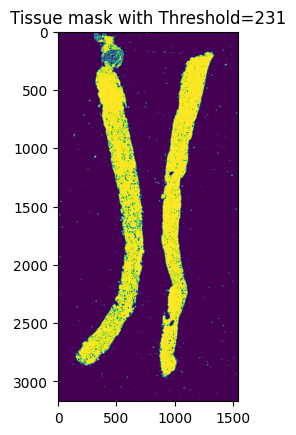

In [14]:
threshold = 231
tissue_binary_mask = 255-threshold_image(np_resized_image, threshold=threshold)

plt.figure()
plt.imshow(tissue_binary_mask)
plt.title(f"Tissue mask with Threshold={threshold}")
plt.show()

## Color normalizating taking into account the tissue mask:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


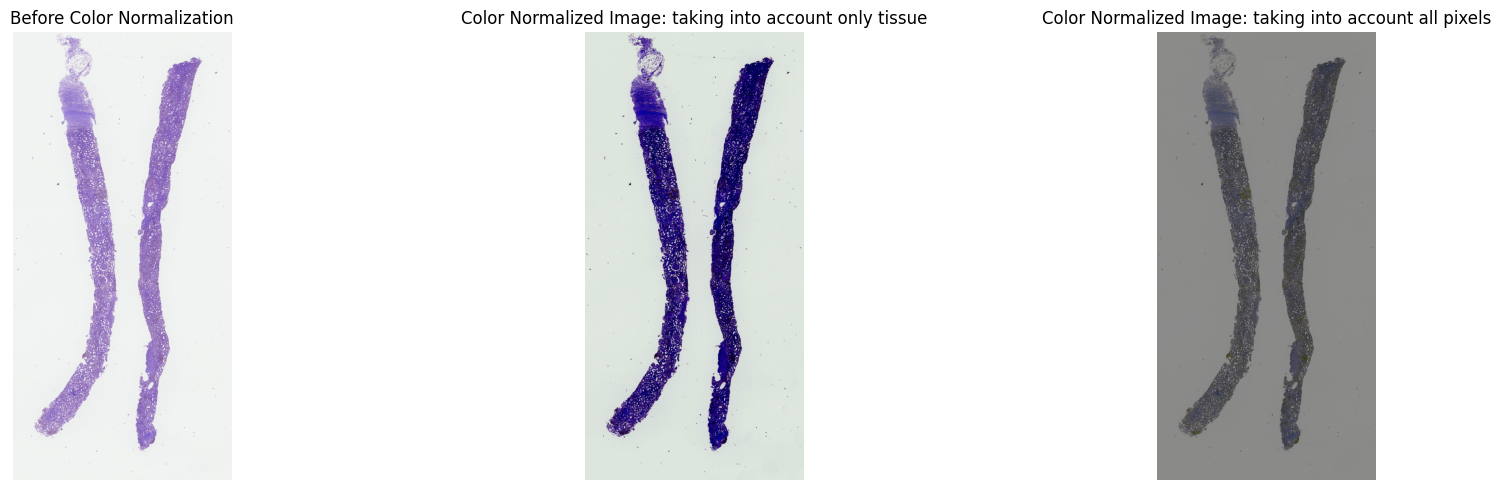

In [15]:
# Step 1: Create a boolean mask from the binary mask
mask = tissue_binary_mask == 255

# Step 2: Scale the image from 0-255 to 0-1
np_image = np_resized_image / 255.0

# Compute the mean and standard deviation for each channel in the masked areas
means = []
stds = []
for channel in range(3):  # Assuming RGB channels
    pixels = np_image[..., channel][mask]
    means.append(np.mean(pixels))
    stds.append(np.std(pixels))

# Step 3: Normalize the image using the computed mean and standard deviation and map to [-1, 1]
normalized_image = np.zeros_like(np_image)
for channel in range(3):
    # Normalize to zero mean and unit variance
    normalized_channel = (np_image[..., channel] - means[channel]) / stds[channel]
    # Scale to [-1, 1]
    normalized_image[..., channel] = 2 * ((normalized_channel - normalized_channel.min()) / 
                                          (normalized_channel.max() - normalized_channel.min())) - 1

# Create a figure to hold the subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))  # 1 row, 3 columns, and set a figure size

# Plot the original image
axs[0].imshow(np_resized_image)
axs[0].set_title("Before Color Normalization")
axs[0].axis('off')  # Turn off axis labels and ticks

# Plot the normalized image taking into account only tissue
axs[1].imshow(normalized_image)
axs[1].set_title("Color Normalized Image: taking into account only tissue")
axs[1].axis('off')

# Plot the fully color normalized image
axs[2].imshow(all_image_color_normalized)
axs[2].set_title("Color Normalized Image: taking into account all pixels")
axs[2].axis('off')

# Display the figure with all subplots
plt.tight_layout()
plt.show()


## WSI to tiles: taking into account the tissue mask:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def tile_image_with_mask(np_image, tissue_binary_mask, patch_size, overlap):
    tiles = []
    step_size = patch_size - overlap
    mask = tissue_binary_mask == 255
    for i in range(0, np_image.shape[0] - patch_size + 1, step_size):
        for j in range(0, np_image.shape[1] - patch_size + 1, step_size):
            # img_patch = np_image[i:i + patch_size, j:j + patch_size]
            mask_patch = mask[i:i + patch_size, j:j + patch_size]
            if np.sum(mask_patch) > 250:
                tiles.append([j, i])
    return tiles

def tile_image_systematic(np_image, patch_size, overlap):
    tiles = []
    step_size = patch_size - overlap
    for i in range(0, np_image.shape[0] - patch_size + 1, step_size):
        for j in range(0, np_image.shape[1] - patch_size + 1, step_size):
            # img_patch = np_image[i:i + patch_size, j:j + patch_size]
            tiles.append([j, i])
    return tiles

def plot_patches(np_image, tiles, title, patch_size):
    fig, ax = plt.subplots(1)
    ax.imshow(np_image)
    ax.set_title(title)
    for tile in tiles:
        # Extract the top-left corner of each patch to place the rectangle
        i, j = tile[1], tile[0]  # Assuming patch contains (i, j) of its origin
        rect = patches.Rectangle((j, i), patch_size, patch_size, linewidth=1,
                                 edgecolor='r', facecolor='none', linestyle='--')
        ax.add_patch(rect)
    plt.show()


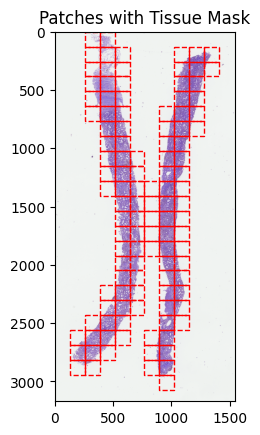

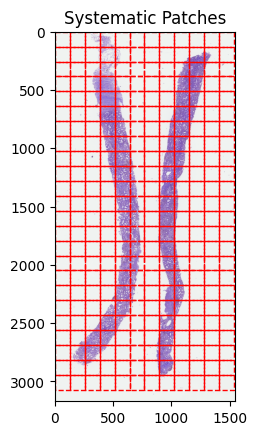

Patches filtred by the mask 114
Patches without filters 288


In [17]:
# Assuming np_resized_image and tissue_binary_mask are defined
patch_size = 128
overlap = 0

# Extract patches using both methods
patches_with_mask = tile_image_with_mask(np_resized_image, tissue_binary_mask, patch_size, overlap)
patches_systematic = tile_image_systematic(np_resized_image, patch_size, overlap)

# Plot both to visualize the difference
plot_patches(np_resized_image, patches_with_mask, "Patches with Tissue Mask", patch_size)
plot_patches(np_resized_image, patches_systematic, "Systematic Patches", patch_size)

print(f'Patches filtred by the mask {len(patches_with_mask)}')
print(f'Patches without filters {len(patches_systematic)}')



## Handling basic artifacts

## Creating basic artifact on the WSI:

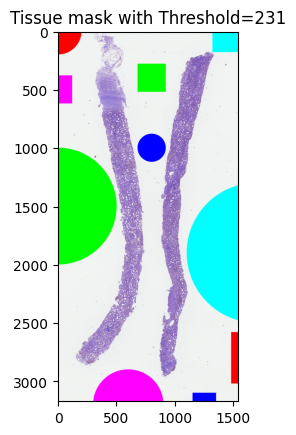

In [18]:
from PIL import Image, ImageDraw

# Assuming np_resized_image is your image array
# Make sure your image is in 'RGB' format. If it's not, you will need to convert it.

# Convert numpy array to PIL Image
image = Image.fromarray(np_resized_image)

# Create a draw object
draw = ImageDraw.Draw(image)

# Define the circle's center and radius
centers = [(0, 0), (0,1500), (800,1000), (1700,1900), (600,3200)]  # The top-left corner of the image
radii = [200, 500, 120, 600, 300]
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255)]  # RGB for red

for center, radius, color in zip(centers, radii, colors):
    # Draw the circle
    draw.ellipse([center[0]-radius, center[1]-radius, center[0]+radius, center[1]+radius], fill=color)


# Data for drawing boxes
centers = [(1500, 0), (0,500), (800,400), (1700,2800), (1250,3200)]
sizes = [180, 120, 120, 220, 100]  # This will be used as half the side length of each square
colors = [(0, 255, 255), (255, 0, 255), (0, 255, 0), (255, 0, 0),  (0, 0, 255)]

# Draw boxes
for center, size, color in zip(centers, sizes, colors):
    # Calculate the top-left and bottom-right corners of the square
    top_left = (center[0] - size, center[1] - size)
    bottom_right = (center[0] + size, center[1] + size)
    draw.rectangle([top_left, bottom_right], fill=color)

# Convert back to numpy array if needed
np_resized_image_modified = np.array(image)

plt.figure()
plt.imshow(np_resized_image_modified)
plt.title(f"Tissue mask with Threshold={threshold}")
plt.show()

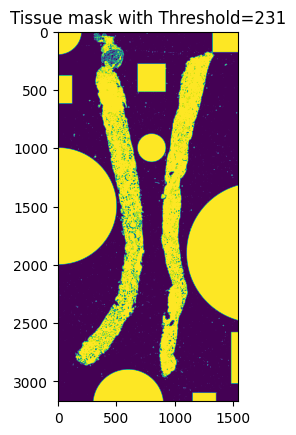

In [19]:
tissue_binary_mask = 255-threshold_image(np_resized_image_modified, threshold=threshold)

plt.figure()
plt.imshow(tissue_binary_mask)
plt.title(f"Tissue mask with Threshold={threshold}")
plt.show()

## Cleaning up artifacts using connected components:

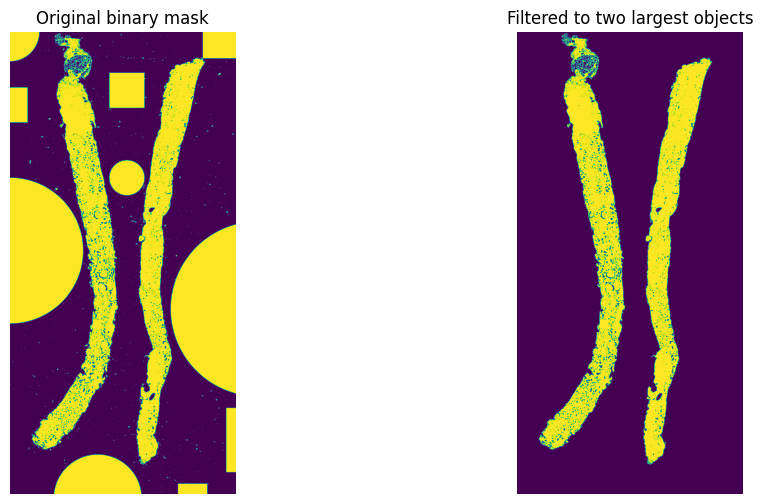

In [20]:
import numpy as np
from skimage import measure, morphology
from skimage.measure import regionprops
import matplotlib.pyplot as plt

# Label the image
label_image = measure.label(tissue_binary_mask)

# Calculate properties of labeled regions
props = regionprops(label_image)

# Sort properties by area in descending order and select the two largest
largest_two = sorted(props, key=lambda x: x.area, reverse=True)[:2]

# Create a new image to store only the two largest objects
filtered_mask = np.zeros_like(tissue_binary_mask)

# Copy the two largest objects back to the new image
for prop in largest_two:
    filtered_mask[label_image == prop.label] = 255

# Display the original and the processed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(tissue_binary_mask)
ax[0].set_title('Original binary mask')
ax[0].axis('off')

ax[1].imshow(filtered_mask)
ax[1].set_title('Filtered to two largest objects')
ax[1].axis('off')

plt.show()


## Using filtred mask to clean the WSI:

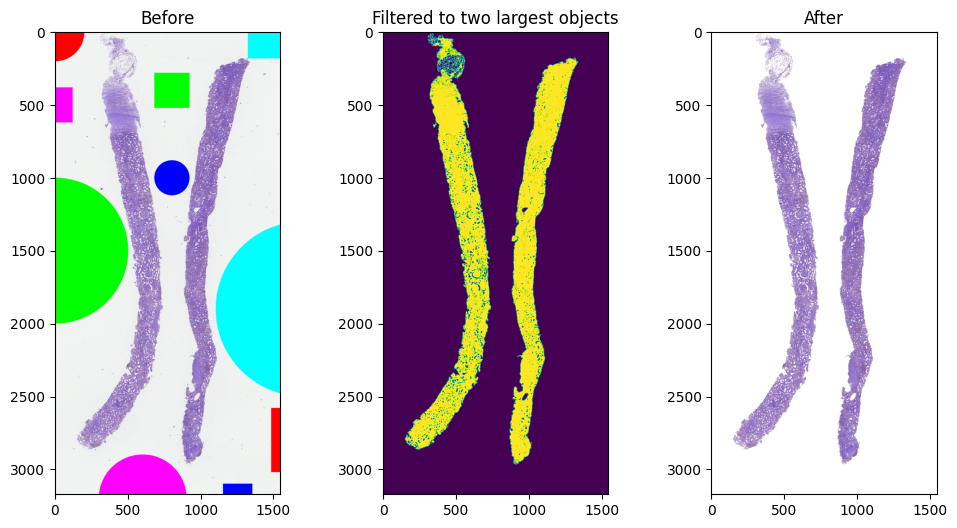

In [21]:
final_image = np_resized_image_modified.copy()
final_image[filtered_mask == 0] = [255,255,255]  # Set non-object pixels to zero

# Plotting the before and after images
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(np_resized_image_modified)
ax[0].set_title('Before')
ax[0].axis('on')

ax[1].imshow(filtered_mask)
ax[1].set_title('Filtered to two largest objects')
ax[1].axis('on')

ax[2].imshow(final_image)
ax[2].set_title('After')
ax[2].axis('on')

plt.show()

## Effect of the artifact on tile extraction:

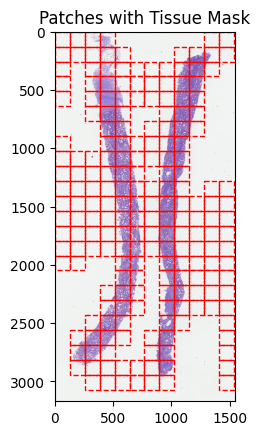

Patches filtred by the mask 204


In [22]:
# Assuming np_resized_image and tissue_binary_mask are defined
patch_size = 128
overlap = 0

# Extract patches using both methods
patches_with_mask = tile_image_with_mask(np_resized_image_modified, tissue_binary_mask, patch_size, overlap)

# Plot both to visualize the difference
plot_patches(np_resized_image, patches_with_mask, "Patches with Tissue Mask", patch_size)

print(f'Patches filtred by the mask {len(patches_with_mask)}')

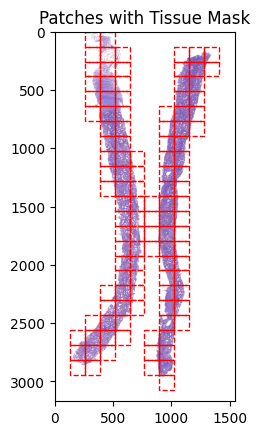

Patches filtred by the mask 113


In [23]:
# Assuming np_resized_image and tissue_binary_mask are defined
patch_size = 128
overlap = 0

# Extract patches using both methods
patches_with_mask = tile_image_with_mask(final_image, filtered_mask, patch_size, overlap)

# Plot both to visualize the difference
plot_patches(final_image, patches_with_mask, "Patches with Tissue Mask", patch_size)

print(f'Patches filtred by the mask {len(patches_with_mask)}')

## Saving tiles into a PNG images:

In [24]:
import os

# Create the directory for storing tiles
os.makedirs('H&E_tiles', exist_ok=True)

# Save the patches to the directory
for coords in patches_with_mask:
    j, i = coords
    tile = final_image[i:i+patch_size, j:j+patch_size]
    tile_image = Image.fromarray(tile)
    tile_image.save(f'H&E_tiles/tile_{j}_{i}.png')

print("Tiles saved successfully.")

Tiles saved successfully.
